> # Μέλη ομάδας

Δημάκης Αντώνιος - sdi1900047

Μεϊντάνης Σωτήριος - sdi1900234

> # Connection to Drive

Μπορεί να αλλάξει από εδώ ο φάκελος όπου γίνεται η αποθήκευση των αρχείων.

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

%cd "/content/drive/MyDrive/DataMining"

Mounted at /content/drive
/content/drive/MyDrive/DataMining




> # Data preprocessing



In [ ]:
import pandas as pd
import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('punkt')
nltk.download('wordnet')

# regex for various special symbols
symbols_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002500-\U00002BEF"  # chinese char
                            u"\U00002702-\U000027B0"
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            u"\U0001f926-\U0001f937"
                            u"\U00010000-\U0010ffff"
                            u"\u2640-\u2642"
                            u"\u2600-\u2B55"
                            u"\u200d"
                            u"\u23cf"
                            u"\u23e9"
                            u"\u231a"
                            u"\ufe0f"  # dingbats
                            u"\u3030"
                            u"\u2026" # ellipsis
                            "]+", flags=re.UNICODE)

# regex for stopwords
stopword_pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')

def remove_stopwords(text):
  return stopword_pattern.sub('', text)

# creating lemmatiser
lemmatizer = WordNetLemmatizer()

# creating stemmer
stemmer = PorterStemmer()

def lemmatise_stem(text):
  word_list = nltk.word_tokenize(text)
  lemmatized_word_list = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
  return ' '.join([stemmer.stem(w) for w in word_list])

def preprocess(tweet):
  tweet = re.sub('#[A-Za-z0-9_]+', '', tweet) # remove hashtags
  tweet = re.sub('@[A-Za-z0-9_]+', '', tweet) # remove mentions
  tweet = symbols_pattern.sub(r'', tweet) # remove special symbols (including emojis)
  tweet = re.sub(r'http\S+', '', tweet)   # remove links
  tweet = tweet.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
  tweet = re.sub('’', ' ', tweet)         # remove quote (not included in string.punctuation)
  tweet = tweet.lower()                   # lower capital letters
  tweet = stopword_pattern.sub('', tweet) # remove stopwords
  tweet = re.sub('\n', ' ', tweet) # remove newline character and replace it with space
  tweet = lemmatise_stem(tweet)    # lemmatise and stem
  return tweet
  
# importing data

df = pd.read_pickle("eclass_all_with_sentiment_v2.pkl")

# filling NaN string values (there are missing values for numerical columns in the data)

df['user_name'] = df['user_name'].fillna("")
df['user_location'] = df['user_location'].fillna("")
df['user_description'] = df['user_description'].fillna("")
df['text'] = df['text'].fillna("")
df['hashtags'] = df['hashtags'].fillna("")
df['source'] = df['source'].fillna("")

# preprocessing/cleaning of the data

df['text'] = df['text'].apply(preprocess)

# keep 30% of data for training and testing

df_limited = df.sample(frac = 0.3, random_state = 5)

# randomly separating data into train and test sets

df_test = df_limited.sample(frac = 0.2, random_state = 5)

df_test.to_pickle('test.pkl')

df_train = df_limited.drop(index = df_test.index)

df_train.to_pickle('train.pkl')

# keep all cleaned text for LDA and analysis

# also clean the hashtags so they are easily searchable in the analysis
df['hashtags'] = df['hashtags'].apply(preprocess)
df.to_pickle('whole.pkl')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!




> # Data analysis



Ορισμοί συναρτήσεων

In [ ]:
import numpy as np
from collections import Counter, OrderedDict
from operator import itemgetter
import nltk
nltk.download('punkt')

def convert_string_to_frequent_words(data_str, N=15):
  tokens = nltk.word_tokenize(data_str)
  tokens_bar = dict(Counter(tokens))
  tokens_bar_frequent = dict(sorted(tokens_bar.items(), key = itemgetter(1), reverse = True)[:N])
  return tokens_bar_frequent

def sentiment_statistics(data, title_text = 'Amount of tweets per sentiment'):
  count_result = dict(data["sentiment"].value_counts())
  df = pd.DataFrame.from_dict(count_result, orient='index', columns=['Tweets'])
  df.plot(kind='bar', title=title_text)
  df.plot(kind='pie', title=title_text, y='Tweets')

def frequent_words_statistics(data):
  arr = data["text"].to_numpy()
  data_str = " ".join(arr)
  tokens_bar_frequent = convert_string_to_frequent_words(data_str)
  df = pd.DataFrame.from_dict(tokens_bar_frequent, orient='index', columns=['Tweets'])
  df.plot(kind='bar', title='Most frequent words among all tweets')

def frequent_words_per_sentiment_tweet_statistics(data):
  neu_tweets = pd.DataFrame.from_dict(convert_string_to_frequent_words(" ".join(data[data["sentiment"] == "NEU"]["text"].to_numpy())), orient='index', columns=['Tweets'])
  neg_tweets = pd.DataFrame.from_dict(convert_string_to_frequent_words(" ".join(data[data["sentiment"] == "NEG"]["text"].to_numpy())), orient='index', columns=['Tweets'])
  pos_tweets = pd.DataFrame.from_dict(convert_string_to_frequent_words(" ".join(data[data["sentiment"] == "POS"]["text"].to_numpy())), orient='index', columns=['Tweets'])
  neu_tweets.plot(kind='bar', title='Most frequent words among neutral tweets')
  neg_tweets.plot(kind='bar', title='Most frequent words among negative tweets')
  pos_tweets.plot(kind='bar', title='Most frequent words among positive tweets')

def vaccine_categories_tweets_statistics(data):
  astrazeneca_tweets = data[data["text"].str.contains("astrazeneca") | data["hashtags"].str.contains("astrazeneca")]
  moderna_pfizer_biontech_tweets = data[data["hashtags"].str.contains("moderna|pfizer|biontech") | data["text"].str.contains("moderna|pfizer|biontech")]
  sentiment_statistics(astrazeneca_tweets, 'Amount of Astrazeneca tweets per sentiment')
  sentiment_statistics(moderna_pfizer_biontech_tweets, 'Amount of Pfizer/Moderna tweets per sentiment')

def number_of_tweets_per_month_statistics(data):
  months_df = data["date"].str[0:7]
  months_statistics = dict(months_df.value_counts())
  df = pd.DataFrame.from_dict(months_statistics, orient='index', columns=['Tweets'])
  df = df.sort_index(axis=0,ascending=True)
  df.plot(kind='bar', title='Amount of tweets per month')
  # display(months_dfs[11])

def verified_tweets_statistics(data):
  verified_tweets = data[data["user_verified"] == True]
  unverified_tweets = data[data["user_verified"] == False]
  sentiment_statistics(verified_tweets, 'Amount of tweets by verified users per sentiment')
  sentiment_statistics(unverified_tweets, 'Amount of tweets by unverified users per sentiment')

def source_tweets_statistics(data):
  web_tweets = data[data["source"] == "Twitter Web App"]
  android_tweets = data[data["source"] == "Twitter for Android"]
  ios_tweets = data[data["source"] == "Twitter for iPhone"]
  tweetdeck_tweets = data[data["source"] == "TweetDeck"]
  sentiment_statistics(web_tweets, 'Amount of tweets posted through the web per sentiment')
  sentiment_statistics(android_tweets, 'Amount of tweets posted through Android per sentiment')
  sentiment_statistics(ios_tweets, 'Amount of tweets posted through iOs per sentiment')
  sentiment_statistics(tweetdeck_tweets, 'Amount of tweets posted through TweetDeck per sentiment')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Εξαγωγή αποτελεσμάτων

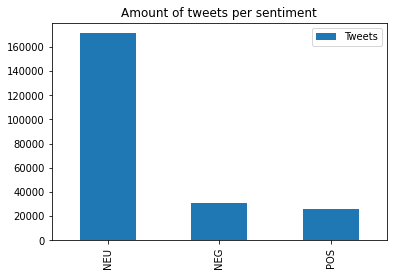

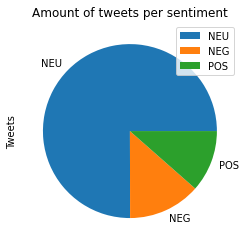

In [ ]:
import pandas as pd

df = pd.read_pickle("whole.pkl")

sentiment_statistics(df)

Βλέπουμε πως τα περισσότερα tweets είναι ουδέτερα, με περίπου ίσο αριθμό αρνητικών και θετικών. Από το bar chart βλέπουμε εύκολα πως τα αρνητικά είναι λίγο περισσότερα από τα θετικά, ενώ με το pie chart βλέπουμε εύκολα πως τα ουδέτερα είναι περίπου τα 3/4 του συνόλου.

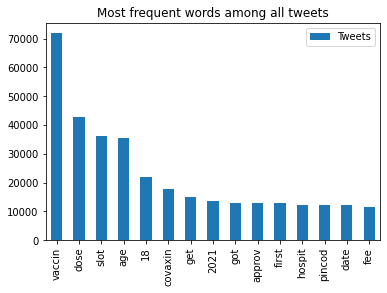

In [ ]:
frequent_words_statistics(df)

Βλέπουμε πως οι πιο συχνές λέξεις έχουν να κάνουν με τα εμβόλια, που είναι λογικό εφόσον τα tweets επιλέχθηκαν να είναι πάνω σε αυτό το θέμα.

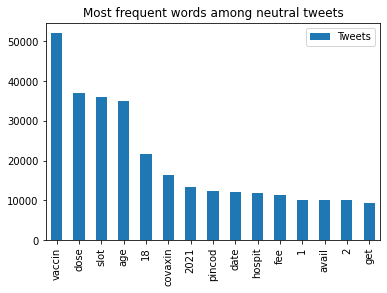

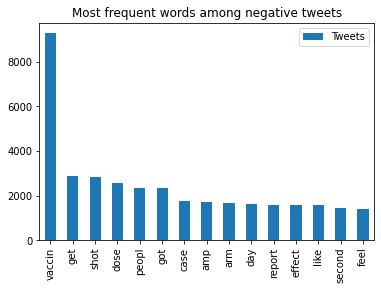

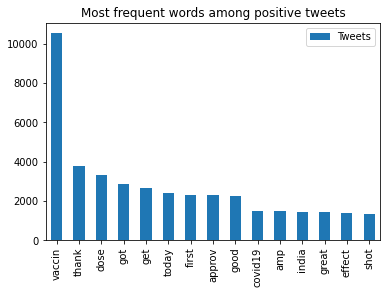

In [ ]:
frequent_words_per_sentiment_tweet_statistics(df)

Όλες οι κατηγορίες έχουν ως πρώτη λέξη το θέμα/stem vaccin (vaccine, vaccinated, vaccinate), που ήταν αναμενόμενο.

Από τις λέξεις των ουδέτερων, φαίνεται να δίνουν πληροφορίες σχετικά με τον εμβολιασμό, την ηλικία εμβολιασμού, την διαθεσιμότητα εμβολίων, κτλ.

Από τις λέξεις των αρνητικών φαίνεται πως χρησιμοποιούν την λέξη shot, που έχει ελαφρώς πιο αρνητική χροιά από την λέξη dose, και λέξεις που έχουν να κάνουν με τις παρενέργειες που αισθάνονται οι εμβολιασμένοι (arm, effect, feel).

Στα θετικά υπάρχουν ξεκάθαρα θετικές λέξεις (good, great, thank), και λέξεις που φαίνεται να χρησιμοποιούνται σε tweets που δηλώνουν εμβολιασμό (dose, got, today, first (π.χ. «σήμερα έκανα την πρώτη μου δόση»)).

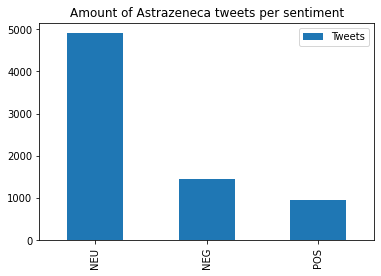

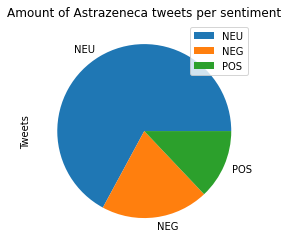

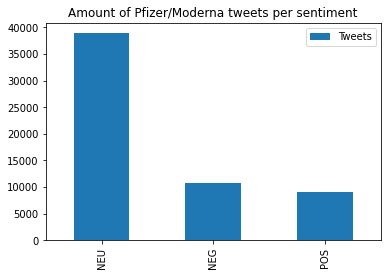

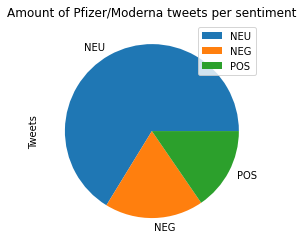

In [ ]:
vaccine_categories_tweets_statistics(df)

Βλέπουμε πως πολύ περισσότερα tweets αναφέρουν pfizer/moderna παρά astrazeneca.

Και στις δύο κατηγορίες, το πσοοστό ουδέτερων tweet είναι μικρότερο από το ποσοστό στο σύνολο των δεδομένων.

Στα astrazeneca, η αναλογία αρνητικών/θετικά είναι μεγαλύτερη από ό,τι στα pfizer/moderna.

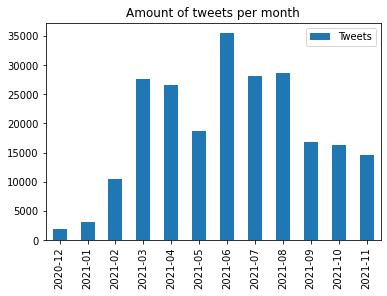

In [ ]:
number_of_tweets_per_month_statistics(df)

Τα δεδομένα μας είναι στα αγγλικά και αφορούν κυρίως έναν πληθυσμό από της ΗΠΑ. Βλέπουμε μια σημαντική αύξηση στον αριθμό των tweets σχετικά με τα εμβόλια τον Μάρτιο του 2021. Αυτό μπορεί να οφείλεται στο γεγονός πως εκείνο τον μήνα το εμβόλιο έγινε διαθέσιμο για όλους του ενήλικες στις πρώτες πολιτείες των ΗΠΑ. Βλέπουμε άλλη μία σημαντική αύξηση τον Ιούνιο, που μπορεί να οφείλεται στην αναγνώριση της μετάλλαξης Δέλτα εκείνη την περίοδο, για την οποία τα υπάρχοντα εμβόλια παρέχουν μικρότερη προστασία.

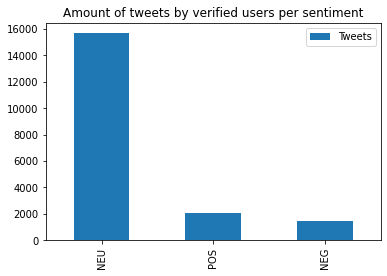

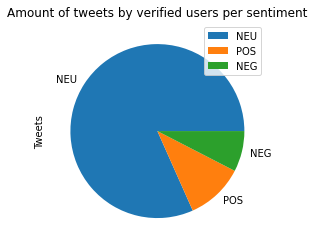

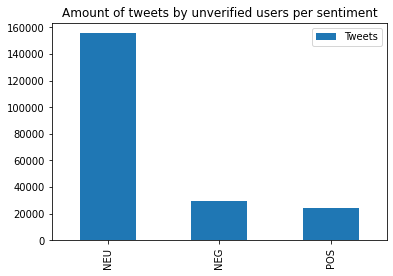

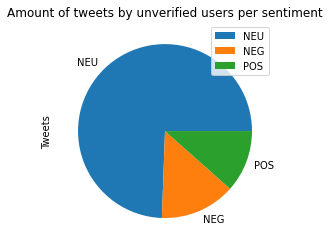

In [ ]:
verified_tweets_statistics(df)

Βλέπουμε πως τα tweets από verified λογαριασμούς είναι σε μεγαλύτερο ποσοστό ουδέτερα σε σχέση με το σύνολο των δεδομένων. Επίσης είναι η μόνη που έχουμε δεί μέχρι τώρα στην οποία τα θετικά είναι περισσότερα από τα αρνητικά.

Τα tweets από unverified, που είναι και πολύ περισσότερα, ακολουθούν περίπου την ίδια κατανομή με το σύνολο.

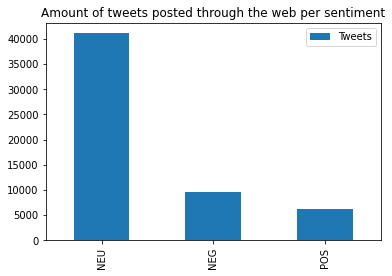

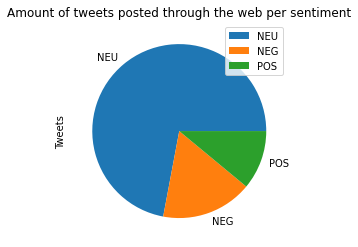

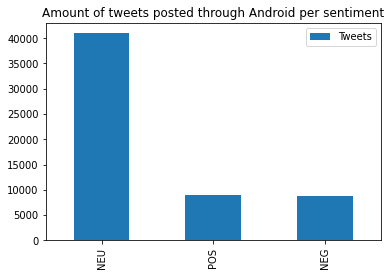

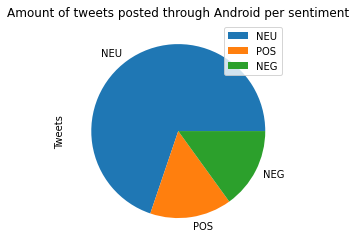

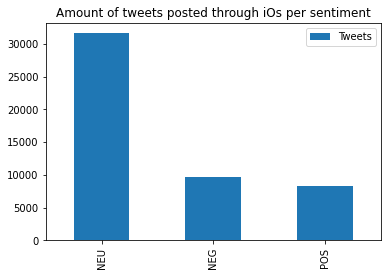

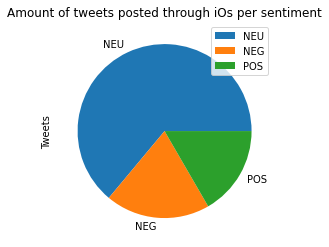

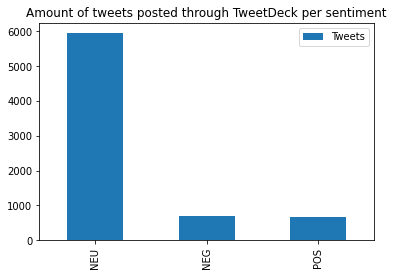

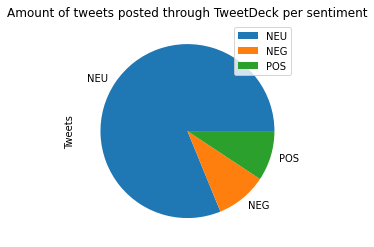

In [ ]:
source_tweets_statistics(df)

Βλέπουμε πως τα tweets από τα τρία μεγαλύτερα μέσα (Web, Android, iOs) έχουν πιο έντονες απόψεις για τα εμβόλια, με το ποσοστό ουδέτερων tweets να είναι μικρότερο σε σχέση με το σύνολο των δεδομένων. αυτό ισχύει περισσότερο για τους χρήστες iOs συγκεκριμένα.

Εν μέρει αυτό εξηγείται γιατί πολλά από τα tweets από ειδησεογραφικές οργανώσεις και υπηρεσίες που ενημερώνουν για την διαθεσιμότητα εμβολίων, των οποίων τα tweets είναι γενικά ουδέτερα, χρησιμοποιούν άλλα μέσα όπως το TweetDeck, που δίνουν δυνατότητες αυτοματοποίησης.

Τα tweets από Android επίσης έχουν οριακά περοσσότερα θετικά tweets από ό,τι αρνητικά.

> # Vectorisation

In [ ]:
import pickle

tweets_train = pd.read_pickle('train.pkl')
tweets_train = tweets_train["text"].to_numpy()

tweets_test = pd.read_pickle('test.pkl')
tweets_test = tweets_test["text"].to_numpy()

> ## Bag Of Words



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_features=1000)

bow_train = bow_vectorizer.fit_transform(tweets_train)
bow_train_pickle = open('bow_train.pkl', 'wb')
pickle.dump(bow_train, bow_train_pickle)
bow_train_pickle.close()

bow_test = bow_vectorizer.transform(tweets_test)
bow_test_pickle = open('bow_test.pkl', 'wb')
pickle.dump(bow_test, bow_test_pickle)
bow_test_pickle.close()



> ## TF-IDF



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000)

tfidf_train = tfidf_vectorizer.fit_transform(tweets_train)

tfidf_train_pickle = open('tfidf_train.pkl', 'wb')
pickle.dump(tfidf_train, tfidf_train_pickle)
tfidf_train_pickle.close()

tfidf_test = tfidf_vectorizer.transform(tweets_test)
tfidf_test_pickle = open('tfidf_test.pkl', 'wb')
pickle.dump(tfidf_test, tfidf_test_pickle)
tfidf_test_pickle.close()

> ## Word Embeddings

In [ ]:
from gensim.models import Word2Vec
#import gensim.downloader
import numpy as np

def words_to_sentence(text, model):
    words = text.split()
    vector = np.zeros((model.vector_size, ), dtype='float32')
    word_amount = 0
    for word in words:
        if word in model.wv.vocab:
            word_amount += 1
            vector = np.add(vector, model[word])
    if (word_amount > 0):
        vector = np.divide(vector, word_amount)
    return vector

tokenizer = lambda x: x.split()
tokenized_tweets = np.array([tokenizer(tweet) for tweet in tweets_train]) # tokenizing
word_embeddings_model = Word2Vec(
          tokenized_tweets,
          size=200, # desired no. of features/independent variables
          window=5, # context window size
          min_count=2,
          sg = 1, # 1 for skip-gram model
          hs = 0,
          negative = 10, # for negative sampling
          workers= 2, # no.of cores
          seed = 34)
word_embeddings_model.train(tokenized_tweets, total_examples=len(tweets_train), epochs=20)

word_embeddings_train = []
for tweet in tweets_train:
  word_embeddings_train.append(words_to_sentence(tweet, word_embeddings_model))
word_embeddings_train_pickle = open('word_embeddings_train.pkl', 'wb')
pickle.dump(word_embeddings_train, word_embeddings_train_pickle)
word_embeddings_train_pickle.close()

word_embeddings_test = []
for tweet in tweets_test:
  word_embeddings_test.append(words_to_sentence(tweet, word_embeddings_model))
word_embeddings_test_pickle = open('word_embeddings_test.pkl', 'wb')
pickle.dump(word_embeddings_test, word_embeddings_test_pickle)
word_embeddings_test_pickle.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.




> # Training models



In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, GridSearchCV
import pickle

train_sentiment = pd.read_pickle('train.pkl')
train_sentiment = train_sentiment["sentiment"].to_numpy()

test_sentiment = pd.read_pickle('test.pkl')
test_sentiment = test_sentiment["sentiment"].to_numpy()

# using smaller dataset for validation so that the fitting time is reasonable
new_size = round(train_sentiment.shape[0]/15)
train_sentiment_val = train_sentiment[:new_size]

> ## Using BOW


In [ ]:
bow_train_pickle = open('bow_train.pkl', 'rb')
bow_train = pickle.load(bow_train_pickle)
bow_train_pickle.close()

bow_test_pickle = open('bow_test.pkl', 'rb')
bow_test = pickle.load(bow_test_pickle)
bow_test_pickle.close()

# using smaller dataset for validation so that the fitting time is reasonable
bow_train_val = bow_train[:new_size]

> ### SVM


> #### 10-fold Cross Validation

In [ ]:
from sklearn.svm import SVC

param_grid = {'C': [0.1, 1, 10, 100],  
              'degree': [2, 3],
              'gamma': ['scale', 'auto'],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}  

kfold = KFold(n_splits=10)
bow_svm_grid = GridSearchCV(estimator=SVC(), param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=kfold)
bow_svm_grid.fit(bow_train_val, train_sentiment_val)
print(bow_svm_grid.best_params_)

{'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


Προκύπτει πως η καλύτερη τιμή της υπερπαραμέτρου του kernel είναι "linear", και οι υπόλοιπες στο default, άρα έτσι θα γίνει η εκπαίδευση.

In [ ]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear')
svm_model.fit(bow_train, train_sentiment)
bow_svm_pred = svm_model.predict(bow_test)
print(classification_report(test_sentiment, bow_svm_pred))

              precision    recall  f1-score   support

         NEG       0.69      0.37      0.49      1814
         NEU       0.84      0.95      0.89     10290
         POS       0.70      0.50      0.58      1588

    accuracy                           0.82     13692
   macro avg       0.74      0.61      0.65     13692
weighted avg       0.80      0.82      0.80     13692



> ### Random Forest

> #### 10-fold Cross Validation

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': [50, 100, 150, 200],  
              'criterion': ['gini', 'entropy'],
              'max_features': ['sqrt', 'log2', None]}  

kfold = KFold(n_splits=10)
bow_forest_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=kfold)
bow_forest_grid.fit(bow_train_val, train_sentiment_val)
print(bow_forest_grid.best_params_)

{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 150}


Προκύπτει πως η καλύτερη τιμή της υπερπαραμέτρου του n_estimators είναι 150, και οι υπόλοιπες στο default (το max_features στο auto είναι ίδιο με "sqrt"), άρα έτσι θα γίνει η εκπαίδευση.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators = 150)
forest_model.fit(bow_train, train_sentiment)
bow_forest_pred = forest_model.predict(bow_test)
print(classification_report(test_sentiment, bow_forest_pred))

              precision    recall  f1-score   support

         NEG       0.67      0.43      0.52      1814
         NEU       0.85      0.93      0.89     10290
         POS       0.67      0.55      0.60      1588

    accuracy                           0.82     13692
   macro avg       0.73      0.64      0.67     13692
weighted avg       0.81      0.82      0.81     13692



> ### KNN

> #### 10-fold Cross Validation

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': [3, 5, 7, 9],  
              'weights': ['uniform', 'distance']}  

kfold = KFold(n_splits=10)
bow_knn_grid = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=kfold)
bow_knn_grid.fit(bow_train_val, train_sentiment_val)
print(bow_knn_grid.best_params_)

{'n_neighbors': 3, 'weights': 'uniform'}


Προκύπτει πως η καλύτερη τιμή της υπερπαραμέτρου του weights είναι 
"uniform" και της n_neighbors 3, άρα έτσι θα γίνει η εκπαίδευση.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3, weights='uniform')
knn_model.fit(bow_train, train_sentiment)
bow_knn_pred = knn_model.predict(bow_test)
print(classification_report(test_sentiment, bow_knn_pred))

              precision    recall  f1-score   support

         NEG       0.46      0.26      0.33      1814
         NEU       0.81      0.93      0.86     10290
         POS       0.60      0.30      0.40      1588

    accuracy                           0.77     13692
   macro avg       0.62      0.50      0.53     13692
weighted avg       0.74      0.77      0.74     13692



Για το bag-of-words καλύτερος classifier προκύπτει το random forest, με macro average f1-score 67%.

> ## Using TFIDF


In [ ]:
tfidf_train_pickle = open('tfidf_train.pkl', 'rb')
tfidf_train = pickle.load(tfidf_train_pickle)
tfidf_train_pickle.close()

tfidf_test_pickle = open('tfidf_test.pkl', 'rb')
tfidf_test = pickle.load(tfidf_test_pickle)
tfidf_test_pickle.close()

# using smaller dataset for validation so that the fitting time is reasonable
tfidf_train_val = tfidf_train[:new_size]

> ### SVM

> #### 10-fold Cross Validation

In [ ]:
from sklearn.svm import SVC

param_grid = {'C': [0.1, 1, 10, 100],  
              'degree': [2, 3],
              'gamma': ['scale', 'auto'],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}  

kfold = KFold(n_splits=10)
tfidf_svm_grid = GridSearchCV(estimator=SVC(), param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=kfold)
tfidf_svm_grid.fit(tfidf_train_val, train_sentiment_val)
print(tfidf_svm_grid.best_params_)

{'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


Προκύπτει πως η καλύτερη τιμή της υπερπαραμέτρου του kernel είναι "linear" και της C είναι 10, και οι υπόλοιπες στο default, άρα έτσι θα γίνει η εκπαίδευση.

In [ ]:
from sklearn.svm import SVC

svm_model = SVC(C=10, kernel='linear')
svm_model.fit(tfidf_train, train_sentiment)
tfidf_svm_pred = svm_model.predict(tfidf_test)
print(classification_report(test_sentiment, tfidf_svm_pred))

              precision    recall  f1-score   support

         NEG       0.69      0.39      0.50      1814
         NEU       0.84      0.95      0.89     10290
         POS       0.71      0.49      0.58      1588

    accuracy                           0.82     13692
   macro avg       0.75      0.61      0.66     13692
weighted avg       0.81      0.82      0.80     13692



> ### Random Forest

> #### 10-fold Cross Validation

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': [50, 100, 150, 200],  
              'criterion': ['gini', 'entropy'],
              'max_features': ['sqrt', 'log2', None]}  

kfold = KFold(n_splits=10)
tfidf_forest_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=kfold)
tfidf_forest_grid.fit(tfidf_train_val, train_sentiment_val)
print(tfidf_forest_grid.best_params_)

{'criterion': 'gini', 'max_features': None, 'n_estimators': 200}


Προκύπτει πως η καλύτερη τιμή της υπερπαραμέτρου του n_estimators είναι 200, του max_features το None, και οι υπόλοιπες στο default, άρα έτσι θα γίνει η εκπαίδευση.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators=200, max_features=None)
forest_model.fit(tfidf_train, train_sentiment)
tfidf_forest_pred = forest_model.predict(tfidf_test)
print(classification_report(test_sentiment, tfidf_forest_pred))

              precision    recall  f1-score   support

         NEG       0.66      0.43      0.52      1814
         NEU       0.85      0.93      0.89     10290
         POS       0.68      0.53      0.60      1588

    accuracy                           0.82     13692
   macro avg       0.73      0.63      0.67     13692
weighted avg       0.81      0.82      0.81     13692



> ### KNN

> #### 10-fold Cross Validation

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': [3, 5, 7, 9],  
              'weights': ['uniform', 'distance']}  

kfold = KFold(n_splits=10)
tfidf_knn_grid = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=kfold)
tfidf_knn_grid.fit(tfidf_train_val, train_sentiment_val)
print(tfidf_knn_grid.best_params_)

{'n_neighbors': 3, 'weights': 'uniform'}


Προκύπτει πως η καλύτερη τιμή της υπερπαραμέτρου του weights είναι "uniform" και της n_neighbors 3, άρα έτσι θα γίνει η εκπαίδευση.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3, weights='uniform')
knn_model.fit(tfidf_train, train_sentiment)
tfidf_knn_pred = knn_model.predict(tfidf_test)
print(classification_report(test_sentiment, tfidf_knn_pred))

              precision    recall  f1-score   support

         NEG       0.48      0.37      0.41      1814
         NEU       0.83      0.91      0.86     10290
         POS       0.59      0.38      0.47      1588

    accuracy                           0.77     13692
   macro avg       0.63      0.55      0.58     13692
weighted avg       0.75      0.77      0.76     13692



Για το tf-idf καλύτερος classifier προκύπτει το random forest, με macro average f1-score 67%.

> ## Using Word Embeddings

In [ ]:
word_embeddings_train_pickle = open('word_embeddings_train.pkl', 'rb')
word_embeddings_train = pickle.load(word_embeddings_train_pickle)
word_embeddings_train_pickle.close()

word_embeddings_test_pickle = open('word_embeddings_test.pkl', 'rb')
word_embeddings_test = pickle.load(word_embeddings_test_pickle)
word_embeddings_test_pickle.close()

# using smaller dataset for validation so that the fitting time is reasonable
word_embeddings_train_val = word_embeddings_train[:new_size]

> ### SVM

> #### 10-fold Cross Validation

In [ ]:
from sklearn.svm import SVC

param_grid = {'C': [0.1, 1, 10, 100],  
              'degree': [2, 3],
              'gamma': ['scale', 'auto'],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}  

kfold = KFold(n_splits=10)
word_embeddings_svm_grid = GridSearchCV(estimator=SVC(), param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=kfold)
word_embeddings_svm_grid.fit(word_embeddings_train_val, train_sentiment_val)
print(word_embeddings_svm_grid.best_params_)

{'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


Προκύπτει πως η καλύτερη τιμή της υπερπαραμέτρου C είναι 10, και οι υπόλοιπες στο default, άρα έτσι θα γίνει η εκπαίδευση.

In [ ]:
from sklearn.svm import SVC

svm_model = SVC(C=10)
svm_model.fit(word_embeddings_train, train_sentiment)
word_embeddings_svm_pred = svm_model.predict(word_embeddings_test)
print(classification_report(test_sentiment, word_embeddings_svm_pred))

              precision    recall  f1-score   support

         NEG       0.68      0.51      0.58      1814
         NEU       0.86      0.94      0.90     10290
         POS       0.74      0.54      0.63      1588

    accuracy                           0.83     13692
   macro avg       0.76      0.66      0.70     13692
weighted avg       0.82      0.83      0.82     13692



> ### Random Forest

> #### 10-fold Cross Validation

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': [50, 100, 150, 200],  
              'criterion': ['gini', 'entropy'],
              'max_features': ['sqrt', 'log2', None]}  

kfold = KFold(n_splits=10)
word_embeddings_forest_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=kfold)
word_embeddings_forest_grid.fit(word_embeddings_train_val, train_sentiment_val)
print(word_embeddings_forest_grid.best_params_)

{'criterion': 'entropy', 'max_features': None, 'n_estimators': 50}


Προκύπτει πως η καλύτερη τιμή της υπερπαραμέτρου του n_estimators είναι 50, του max_features το None και του criterion "entropy", άρα έτσι θα γίνει η εκπαίδευση.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators=50, criterion='entropy', max_features=None)
forest_model.fit(word_embeddings_train, train_sentiment)
word_embeddings_forest_pred = forest_model.predict(word_embeddings_test)
print(classification_report(test_sentiment, word_embeddings_forest_pred))

              precision    recall  f1-score   support

         NEG       0.68      0.30      0.41      1814
         NEU       0.80      0.97      0.88     10290
         POS       0.77      0.24      0.37      1588

    accuracy                           0.80     13692
   macro avg       0.75      0.50      0.55     13692
weighted avg       0.78      0.80      0.76     13692



> ### KNN

> #### 10-fold Cross Validation

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': [3, 5, 7, 9],  
              'weights': ['uniform', 'distance']}  

kfold = KFold(n_splits=10)
word_embeddings_knn_grid = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=kfold)
word_embeddings_knn_grid.fit(word_embeddings_train_val, train_sentiment_val)
print(word_embeddings_knn_grid.best_params_)

{'n_neighbors': 3, 'weights': 'uniform'}


Προκύπτει πως η καλύτερη τιμή της υπερπαραμέτρου του weights είναι "distance" και της n_neighbors 3, άρα έτσι θα γίνει η εκπαίδευση.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3, weights='uniform')
knn_model.fit(word_embeddings_train, train_sentiment)
word_embeddings_knn_pred = knn_model.predict(word_embeddings_test)
print(classification_report(test_sentiment, word_embeddings_knn_pred))

              precision    recall  f1-score   support

         NEG       0.46      0.48      0.47      1814
         NEU       0.85      0.88      0.86     10290
         POS       0.60      0.42      0.50      1588

    accuracy                           0.77     13692
   macro avg       0.64      0.59      0.61     13692
weighted avg       0.77      0.77      0.77     13692



Για το tf-idf καλύτερος classifier προκύπτει το svm, με macro average f1-score 70%. Σημαντική πτώση παρατηρείται στο random forest με το συγκεκριμένο vectorisation. Αν δεν είμασταν άτυχοι με την επιλογή των δεδομένων εκπαίδευσης/ελέγχου, τότε φαίνεται να μην ταιριάζει αυτό το vectorisation στον συγκεκριμένο classifier.

Συνολικά, ο καλύτερος συνδυασμός φαίνεται να είναι word embeddings/svm.

\begin{array}{|c|c|} \hline
f1-score & BOW & TFIDF & Word Embeddings \\ \hline
SVM & 0.65 & 0.66 & {\bf 0.70} \\
RandomForest & 0.67 & 0.67 & 0.55 \\
KNN & 0.53 & 0.58 & 0.61 \\ \hline
\end{array}

\begin{array}{|c|c|} \hline
precision & BOW & TFIDF & Word Embeddings \\ \hline
SVM & 0.74 & 0.75 & {\bf 0.76} \\
RandomForest & 0.73 & 0.73 & 0.75 \\
KNN & 0.62 & 0.63 & 0.64 \\ \hline
\end{array}

\begin{array}{|c|c|} \hline
recall & BOW & TFIDF & Word Embeddings \\ \hline
SVM & 0.61 & 0.61 & {\bf 0.66} \\
RandomForest & 0.64 & 0.63 & 0.50 \\
KNN & 0.50 & 0.55 & 0.59 \\ \hline
\end{array}

Εδώ βλέπουμε ότι για κάποιον λόγο το recall στο random forest ακολουθεί «αντίθετη» πορεία από τις άλλες μετρικές και τους άλλους classifiers, αφού πέφτει καθώς πηγαίνουμε από bag-of-words σε tf-idf και έπειτα σε word embeddings. Από εκεί προκύπτει και η αναπάντεχη πτώση του f1-score στο random forest με word embeddings.

\begin{array}{|c|c|} \hline
accuracy & BOW & TFIDF & Word Embeddings \\ \hline
SVM & 0.82 & 0.82 & {\bf 0.83} \\
RandomForest & 0.82 & 0.82 & 0.80 \\
KNN & 0.77 & 0.77 & 0.77 \\ \hline
\end{array}

Ακόμα και το accuracy πέφτει λίγο στο random forest όταν πάμε στα word embeddings, επιβεβαιώνοντας, αν δεν ήμασταν άτυχοι με τα δεδομένα, πως δεν είναι καλός για το συγκεκριμένο πρόβλημα ο συνδυασμός αυτός.

> # Beat the Benchmark

Ξανανοίγουμε τα αρχεία με τα train και test και παίρνουμε από τα αρχικά δεδομένα περισσότερες πληροφορίες για κάθε tweet, που θα χρησιμοποιηθούν στο Beat the Benchmark. Με τον σχολιασμό συγκεκριμένων γραμμών κώδικα μπορούμε να χρησιμοποιήσουμε μόνο ορισμένα χαρακτηριστικά. Από κάτω είναι ασχολίαστα και χρησιμοποιούνται όλα.

In [ ]:
import pandas as pd
import re

# feature extraction functions

import math

def sigmoid(x):
    return (1 / (1 + math.exp(-x)) - 0.5)*2

def extract_age(text):
  return (2022 - int(text.split("-")[0]))/12 # 0 today, 1 when Twitter was founded

def verification_status_int(text):
  if text == True:
    return 1
  else:
    return 0

def count_exclamation(text):
  return sigmoid(text.count('!'))

def count_question(text):
  return sigmoid(text.count('?'))

def count_link(text):
  return sigmoid(text.count('http'))

def count_mention(text):
  return sigmoid(text.count('@'))

# count upper letters, except mentions and links 
def count_upper(text):
  text = re.sub('@[A-Za-z0-9_]+', '', text) # remove mentions
  text = re.sub(r'http\S+', '', text)   # remove links
  count = 0
  for char in text:
    if char.isupper():
      count += 1
  return sigmoid(count/2)

# count upper letters, except mentions and links 
def count_lower(text):
  text = re.sub('@[A-Za-z0-9_]+', '', text) # remove mentions
  text = re.sub(r'http\S+', '', text)   # remove links
  count = 0
  for char in text:
    if char.islower():
      count += 1
  return sigmoid(count)

def count_hashtag(hashtags):
  if hashtags == '':
    return 0
  # amount of items in list represented by string is equal to commas + 1
  return sigmoid(hashtags.count(',') + 1)

def bad_words(text):
  if text.count('experiment'):
    return 1
  return 0

# extracting extra data for the already previously defined train and test sets
df_whole = pd.read_pickle("eclass_all_with_sentiment_v2.pkl")

df_train = pd.read_pickle("train.pkl")

df_train_whole = df_train.merge(df_whole[["id", "text"]], on='id')

# gathering extra data for training set

df_train_features = (df_train_whole['user_created'].apply(extract_age)).to_frame("account_age")
df_train_features.insert(0, 'user_followers', (df_train_whole['user_followers']/100).apply(sigmoid))
df_train_features.insert(0, 'user_verified', df_train_whole['user_verified'].apply(verification_status_int))
df_train_features.insert(0, 'retweets', df_train_whole['retweets'].apply(sigmoid))
df_train_features.insert(0, 'exclamation_amount', df_train_whole['text_y'].apply(count_exclamation))
df_train_features.insert(0, 'question_amount', df_train_whole['text_y'].apply(count_question))
df_train_features.insert(0, 'link_amount', df_train_whole['text_y'].apply(count_link))
df_train_features.insert(0, 'mention_amount', df_train_whole['text_y'].apply(count_mention))
df_train_features.insert(0, 'upper_amount', df_train_whole['text_y'].apply(count_upper))
df_train_features.insert(0, 'lower_amount', df_train_whole['text_y'].apply(count_lower))
df_train_features.insert(0, 'hashtag_amount', df_train_whole['hashtags'].apply(count_hashtag))
df_train_features.insert(0, 'bad_words', df_train_whole['text_y'].apply(bad_words))

df_train_features.to_pickle('train_extra.pkl')

df_train_whole['text_y'] = df_train_whole['text_y'].apply(preprocess)
df_train_whole['user_description'] = df_train_whole['user_description'].apply(preprocess)
df_train_whole['hashtags'] = df_train_whole['hashtags'].apply(preprocess)

df_train_new = (df_train_whole['user_description']+' '+df_train_whole['text_y']+' '+df_train_whole['hashtags']).to_frame("new_text")

df_train_new.to_pickle('train_new.pkl')

# gathering extra data for testing set

df_test = pd.read_pickle("test.pkl")

df_test_whole = df_test.merge(df_whole[["id", "text"]], on='id')

df_test_features = (df_test_whole['user_created'].apply(extract_age)).to_frame("account_age")
df_test_features.insert(0, 'user_followers', (df_test_whole['user_followers']/100).apply(sigmoid))
df_test_features.insert(0, 'user_verified', df_test_whole['user_verified'].apply(verification_status_int))
df_test_features.insert(0, 'retweets', df_test_whole['retweets'].apply(sigmoid))
df_test_features.insert(0, 'exclamation_amount', df_test_whole['text_y'].apply(count_exclamation))
df_test_features.insert(0, 'question_amount', df_test_whole['text_y'].apply(count_question))
df_test_features.insert(0, 'link_amount', df_test_whole['text_y'].apply(count_link))
df_test_features.insert(0, 'mention_amount', df_test_whole['text_y'].apply(count_mention))
df_test_features.insert(0, 'upper_amount', df_test_whole['text_y'].apply(count_upper))
df_test_features.insert(0, 'lower_amount', df_test_whole['text_y'].apply(count_lower))
df_test_features.insert(0, 'hashtag_amount', df_test_whole['hashtags'].apply(count_hashtag))
df_test_features.insert(0, 'bad_words', df_test_whole['text_y'].apply(bad_words))

df_test_features.to_pickle('test_extra.pkl')

df_test_whole['text_y'] = df_test_whole['text_y'].apply(preprocess)
df_test_whole['user_description'] = df_test_whole['user_description'].apply(preprocess)
df_test_whole['hashtags'] = df_test_whole['hashtags'].apply(preprocess)

df_test_new = (df_test_whole['user_description']+' '+df_test_whole['text_y']+' '+df_test_whole['hashtags']).to_frame("new_text")

df_test_new.to_pickle('test_new.pkl')

Θα ξανακάνουμε από την αρχή την διαδικασία, χρησιμοποιώντας τον καλύτερο συνδυασμό vectorization-model από πριν (word embeddings + svm) με σκοπό να αυξήσουμε την απόδοση.

Αρχικά κάνουμε ένα καινούργιο vectorisation με word embeddings, αλλάζοντας λίγο τις παραμέτρους.

In [ ]:
from gensim.models import Word2Vec
import numpy as np
import pickle
import pandas as pd

def words_to_sentence(text, model):
    words = text.split()
    vector = np.zeros((model.vector_size, ), dtype='float32')
    word_amount = 0
    for word in words:
        if word in model.wv.vocab:
            word_amount += 1
            vector = np.add(vector, model[word])
    if (word_amount > 0):
        vector = np.divide(vector, word_amount)
    return vector

tweets_train = pd.read_pickle('train.pkl')
tweets_train = tweets_train["text"].to_numpy()

tweets_test = pd.read_pickle('test.pkl')
tweets_test = tweets_test["text"].to_numpy()

#uncomment to vectorise text including hashtags and/or description
#tweets_train = pd.read_pickle('train_new.pkl')
#tweets_train = tweets_train["new_text"].to_numpy()

#tweets_test = pd.read_pickle('test_new.pkl')
#tweets_test = tweets_test["new_text"].to_numpy()

tokenizer = lambda x: x.split()
tokenized_tweets = np.array([tokenizer(tweet) for tweet in tweets_train]) # tokenizing
word_embeddings_model = Word2Vec(
          tokenized_tweets,
          size=400, # desired no. of features/independent variables
          window=4, # context window size
          min_count=2,
          sg = 1, # 1 for skip-gram model
          hs = 0,
          negative = 10, # for negative sampling
          workers= 2, # no.of cores
          seed = 34)
word_embeddings_model.train(tokenized_tweets, total_examples=len(tweets_train), epochs=20)

word_embeddings_train = []
for tweet in tweets_train:
  word_embeddings_train.append(words_to_sentence(tweet, word_embeddings_model))
word_embeddings_train_pickle = open('word_embeddings_train_new.pkl', 'wb')
pickle.dump(word_embeddings_train, word_embeddings_train_pickle)
word_embeddings_train_pickle.close()

word_embeddings_test = []
for tweet in tweets_test:
  word_embeddings_test.append(words_to_sentence(tweet, word_embeddings_model))
word_embeddings_test_pickle = open('word_embeddings_test_new.pkl', 'wb')
pickle.dump(word_embeddings_test, word_embeddings_test_pickle)
word_embeddings_test_pickle.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Έπειτα ενώνουμε με το παραγόμενο διάνυσμα word embeddings για κάθε tweet, το κανονικοποιημένο διάνυσμα χαρακτηριστικών που δημιουργήθηκε προηγουμένως. Περνάμε το αποτέλεσμα στο μοντέλο για εκπαίδευση, και μετράμε την απόδοσή του.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import pickle

# read sentiment
train_sentiment = pd.read_pickle('train.pkl')
train_sentiment = train_sentiment["sentiment"].to_numpy()

test_sentiment = pd.read_pickle('test.pkl')
test_sentiment = test_sentiment["sentiment"].to_numpy()

# read word embeddings
word_embeddings_train_pickle = open('word_embeddings_train_new.pkl', 'rb')
word_embeddings_train = pickle.load(word_embeddings_train_pickle)
word_embeddings_train_pickle.close()

word_embeddings_test_pickle = open('word_embeddings_test_new.pkl', 'rb')
word_embeddings_test = pickle.load(word_embeddings_test_pickle)
word_embeddings_test_pickle.close()

# read extra characteristics
train_extra = pd.read_pickle('train_extra.pkl')

test_extra = pd.read_pickle('test_extra.pkl')

# add extra characteristics to word embeddings
train_extended = np.concatenate((np.array(word_embeddings_train), train_extra.to_numpy()), axis=1)
test_extended = np.concatenate((np.array(word_embeddings_test), test_extra.to_numpy()), axis=1)

# train and predict

# uncomment to not use the extra feature vector
#svm_model = SVC(C=10)
#svm_model.fit(train_extended, train_sentiment)
#extended_pred = svm_model.predict(test_extended)
#print(classification_report(test_sentiment, extended_pred))

svm_model = SVC(C=10)
svm_model.fit(word_embeddings_train, train_sentiment)
extended_pred = svm_model.predict(word_embeddings_test)
print(classification_report(test_sentiment, extended_pred))

              precision    recall  f1-score   support

         NEG       0.65      0.39      0.49      1814
         NEU       0.82      0.94      0.88     10290
         POS       0.66      0.34      0.45      1588

    accuracy                           0.80     13692
   macro avg       0.71      0.56      0.61     13692
weighted avg       0.78      0.80      0.78     13692



Lemmatisation και stemming έγιναν από το προηγούμενο ερώτημα και βελτίωσαν την απόδοση, πριν εφαρμοστούν το μέγιστο f1-score ήταν 0.67, και μετά έγινε 0.70.

Χρησιμοποιώντας word embeddings/svm, έγιναν διάφορες δοκιμές:

Αλλάζοντας μόνο τις παραμέτρους στην δημιουργία word embeddings, βγήκε αυτό το αποτέλεσμα:

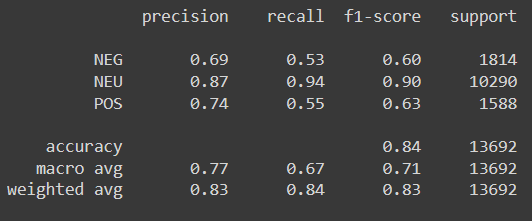


Προσθέτοντας στο κείμενο κάθε tweet και τα hashtags:

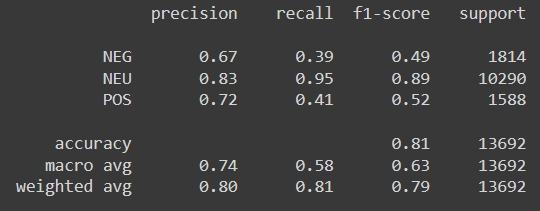

Προσθέτοντας στο κείμενο και την περιγραφή του χρήστη:


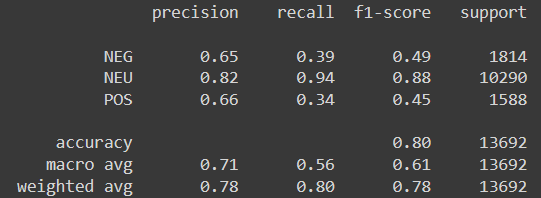

Προσθέτοντας στο κείμενο και την περιγραφή και τα hashtags:

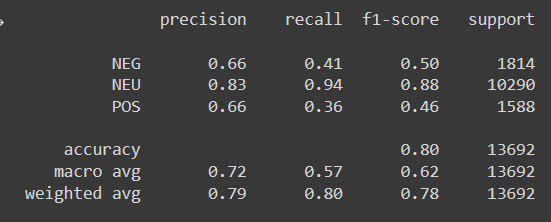

Η απόδοση φαίνεται να χειροτερεύει, άρα κρατήσαμε μόνο το κείμενο του tweet και σε αυτό προσθέσαμε το διάνυσμα των (κανονικοποιημένων) χαρακτηριστικών.

Προσθέτουμε αρχικά την «ηλικία» του λογασιασμού, τον αριθμό ακολούθων, το αν είναι verifed, το πλήθος ερωτηματικών και το πλήθος θαυμαστικών:

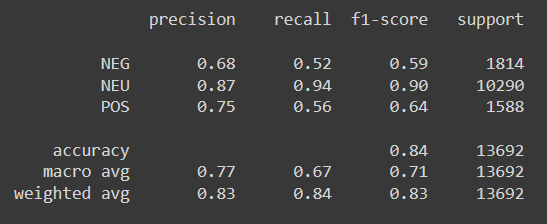

Συνολικά δεν βλέπουμε μεγάλες διαφορές με πριν. Έχουμε λίγο χειρότερη αναγνώριση των αρνητικών tweets, και λίγο καλύτερη αναγνώριση των θετικών. Η αλλαγή είναι τόσο μικρή που μάλλον δεν δείχνει κάτι ουσιαστικό.

Προσθέσαμε μετά πέρα από αυτά τα χαρακτηριστικά και το πλήθος κεφαλαίων και πεζών χαρακτήρων:

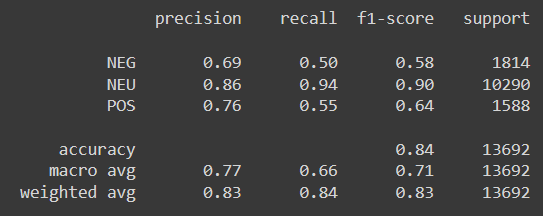

Πάλι έχουμε πολύ μικρές αλλαγές. Φαίνεται αυτήν την φορά το μοντέλο να επιλέγει λίγο πιο συχνά το majority class (neutral), εφόσον πέφτει το recall των minority classes, ανεβαίνει το precision τους, και πέφτει το precision του neutral. Αποφασίσαμε να αφαιρέσουμε το χαρακτηριστικό και να συνεχίσουμε χωρίς αυτό.

Προσθέσαμε έπειτα το πλήθος links και hashtags:

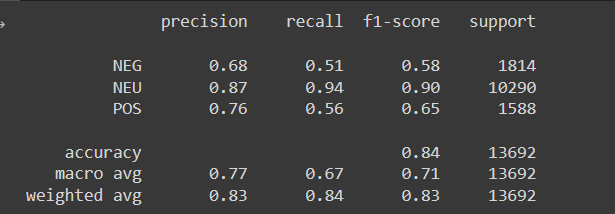

Πάλι ελάχιστες αλλαγές, με πάλι λίγο καλύτερη αναγνώριση positive και χειρότερη negative.

Μετά προσθέσαμε πλήθος mentions και retweets:

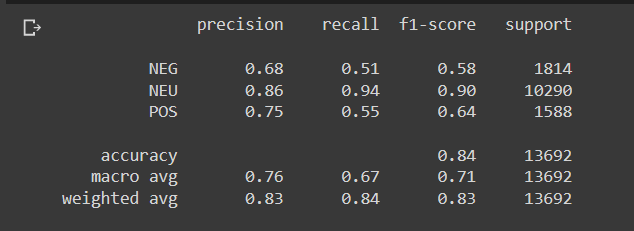

Βλέπουμε μια μικρή πτώση στην αναγνώριση positive χωρίς βελτίωση κάπου αλλού, με αποτέλεσμα μια μικρή πτώση στο συνολικό precision.

Ξαναβάλαμε το πλήθος χαρακτήρων για να δούμε πώς λειτουργεί συνολικά με όλα τα άλλα χαρακτηριστικά:

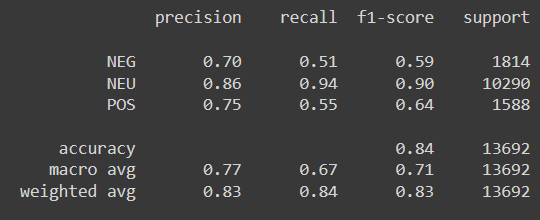

Πάλι βλέπουμε την ίδια μικρή τάση προς το majority class με πριν, με τα αποτελέσματα να είναι συνολικά ελάχιστα καλύτερα.

Τέλος είπαμε να βάλουμε και άλλο ένα χαρακτηριστικό με «κακές λέξεις». Βάλαμε την λέξη «experiment», για να δώσει ίσως πληροφορία για το αν το tweet αποκαλεί πιθανώς το εμβόλιο «πειραματικό»:

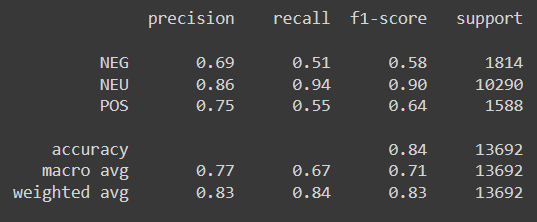

Τα αποτελέσματα είναι ελάχιστα χειρότερα.

Γενικά τα χαρακτηριστικά έκαναν πολύ μικρή διαφορά, με την μόνη σίγουρη βελτίωση να προέρχεται από την αύξηση των στηλών στο vectorisation και το lemmatisation/stemming. Αυτό ίσως να γίνεται επειδή τα λίγα επιπλέον χαρακτηριστικά «τρώγονται» από τις 400 στήλες των word embeddings. Επομένως δεν μπορούμε να βγάλουμε ασφαλή αποτελέσματα, αλλά τα χαρακτηριστικά των mention, των retweets και της λέξης «experiment» φαίνονται να είναι τα «χειρότερα».


> # LDA

> ### Imports

In [ ]:
!pip install pyLDAvis
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk
nltk.download('punkt')

     |████████████████████████████████| 1.7 MB 519 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=41e6d7c9f3b5d582898721d292e23b7a121f4cb8912177f5e06c77c5e83b2afe
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

> ### Running for 10 topics

In [ ]:
# Read the data
tweet_set = pd.read_pickle('whole.pkl')
train_sentiment = train_sentiment["text"].to_numpy()

# Keep half of the set, for a total of 50% of the data, so that the
# program can run in a reasonable amount of time
tweet_set = tweet_set[:len(tweet_set)//2]

# Tokenise data
tweet_set = [nltk.word_tokenize(tweet) for tweet in tweet_set]

# Create Dictionary
id2word = corpora.Dictionary(tweet_set)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in tweet_set]

# Train the model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print metrics
print("coherence:", CoherenceModel(model=lda_model, texts=tweet_set, dictionary=id2word, coherence='c_v').get_coherence())

# Visualise
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

coherence: 0.38807871801708227


/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.281306 -0.189993       1        1  13.052999
0      0.056970 -0.006626       2        1  13.032798
4      0.031468 -0.003050       3        1  12.605950
3     -0.141050  0.261034       4        1  10.108736
7     -0.010266  0.030325       5        1   9.524518
8      0.035704  0.021151       6        1   9.284142
1      0.128884 -0.130158       7        1   8.708764
6      0.034147  0.023621       8        1   8.030755
9      0.079985 -0.014900       9        1   7.883492
5      0.065465  0.008596      10        1   7.767846, topic_info=           Term          Freq         Total Category  logprob  loglift
597         age  36764.000000  36764.000000  Default  30.0000  30.0000
5075       slot  37701.000000  37701.000000  Default  29.0000  29.0000
1074         18  22847.000000  22847.000000  Default  28.0000  28.0000
2063         45  17413.000000  17413.000000  Default  27.0000  27.0000
14       vaccin  17244.000000  17244.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
37976        s2    441.438033   2870.016636  Topic10  -5.1093   0.6831
37977    vydehi    441.438033   2870.016636  Topic10  -5.1093   0.6831
8746      dose2    464.085570   5862.913053  Topic10  -5.0593   0.0188
30980  cloudnin    441.354283   4560.071482  Topic10  -5.1095   0.2199
37930  27062021    430.751805   3572.729296  Topic10  -5.1338   0.4396

[448 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
33910      1  0.160129        0d1
33910      2  0.046376        0d1
33910      3  0.073064        0d1
33910      4  0.160567        0d1
33910      5  0.203006        0d1
...      ...       ...        ...
810        2  0.998034  yesterday
462        1  0.998096        yet
267        7  0.998360          ‘
168        2  0.999141          “
639        2  0.997177          ”

[848 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 4, 8, 9, 2, 7, 10, 6])

Προκύπει topic coherence περίπου 0.39, που είναι σχετικά μικρό. Θα δοκιμάσουμε διαφορετικό αριθμό topics με σκοπό να αυξήσουμε την μετρική.

> ### Finding best number of topics

Ο παρακάτω κώδικας παίρνει πολλή ώρα για να τρέξει. Προκύπτει πως ο καλύτερος αριθμός topics είναι 25 με topic coherence περίπου 0.46. Ψάξαμε και πιο «λεπτομερώς» την περιοχή κοντά στο 25 (23, 24, 25, 26, 27) και βγήκε καλύτερο ο 25, αλλά δεν βάζουμε να τρέξει όλο το range με τέτοια λεπτομέρεια γιατί πρακτικά δεν θα τελειώσει ποτέ (θα διακοπεί η σύνδεση του colab πριν τελειώσει), άρα απο κάτω έχουμε βάλει βήμα 5.

In [ ]:
max_coherence_lda = 0
best_lda_model = None
for num_topics in range(5,30 + 1, 5):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=tweet_set, dictionary=id2word, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  if coherence_lda > max_coherence_lda:
    max_coherence_lda = coherence_lda
    best_lda_model = lda_model
    best_num_topics = num_topics
print("Best number of topics is", best_num_topics, "with topic coherence being", max_coherence_lda)

Best number of topics is 25 with topic coherence being 0.4550581345597653


Για το καλύτερο μοντέλο, οπτικοποιούμε πάλι το αποτέλεσμα.

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(best_lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.359853 -0.124834       1        1  11.087659
10    -0.045080 -0.138640       2        1   9.601917
7     -0.047721 -0.228696       3        1   9.437548
17     0.053420 -0.198935       4        1   5.573999
3     -0.061873 -0.027784       5        1   5.204916
19    -0.065500 -0.029142       6        1   4.860311
4     -0.053828  0.011487       7        1   4.770100
14     0.304893  0.081895       8        1   4.496337
11     0.030452  0.199437       9        1   4.455173
12    -0.062964  0.005545      10        1   4.398747
6     -0.061500  0.017791      11        1   4.234648
8     -0.060042  0.022071      12        1   4.004707
16    -0.062860  0.014841      13        1   3.948592
2     -0.058212  0.055376      14        1   3.749476
0     -0.066762  0.039387      15        1   3.633365
5     -0.063716  0.041190      16        1   3.571116
13    -0.067985  0.030653      17        1   3.507220
18     0.163517  0.147072      18        1   3.262331
9     -0.067504  0.043129      19        1   3.137197
15    -0.066587  0.038158      20        1   3.064641, topic_info=           Term         Freq        Total Category  logprob  loglift
1        vaccin  4093.000000  4093.000000  Default  30.0000  30.0000
48         dose  2288.000000  2288.000000  Default  29.0000  29.0000
21          age  1728.000000  1728.000000  Default  28.0000  28.0000
10         slot  1608.000000  1608.000000  Default  27.0000  27.0000
33          get   904.000000   904.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
2746   interest    25.274773    26.136901  Topic20  -4.9830   3.4517
3268      union    24.739919    25.602046  Topic20  -5.0044   3.4510
2530  philippin    24.421691    25.283819  Topic20  -5.0174   3.4505
3908    whether    22.854671    23.716799  Topic20  -5.0837   3.4482
1538   contract    22.223241    23.085369  Topic20  -5.1117   3.4472

[647 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2        18  0.993287         0
3569     18  0.941290    0100pm
1551      9  0.959989  02072021
2641     18  0.933825    0330pm
4        16  0.965064    0500pm
...     ...       ...       ...
1650     20  0.993113         “
1577     20  0.990566         ”
599       1  0.989280     ₹1145
371       1  0.987685     ₹1200
53        1  0.996901     ₹1410

[621 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 11, 8, 18, 4, 20, 5, 15, 12, 13, 7, 9, 17, 3, 1, 6, 14, 19, 10, 16])

Παρατηρήσαμε σε δοκιμές που κάναμε πως γενικά με περισσότερα δεδομένα το topic coherence φαίνεται να πέφτει, τουλάχιστον κρατώντας σταθερά τα 10 topics.